In [1]:
#pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#this is for future matplotlib graphs/plots
plt.rcParams['figure.figsize'] = [16, 10]

In [3]:
#Manhattan Border
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

In [4]:
#open zip files
train = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')
test = pd.read_csv('test.zip', compression='zip', header=0, sep=',', quotechar='"')

In [5]:
#set future format and a quick look at a description of data 
pd.set_option('display.float.format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [6]:
#cut down trip duration to be within only 2 stdev. Cutting out long and short trips
#gather the mean of the trip duration
m = np.mean(train['trip_duration'])
#grab the std dev of the trip duration
s = np.std(train['trip_duration'])
#remove 2 std dev from both sides 
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [7]:
#Show only pickups and dropoffs within Manhattan boundaires 
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [8]:
#turn all pickup and dropoff datetime stamps into specific date, month, day, hour, and day of week
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['pickup_date'] = train['pickup_datetime'].dt.date
train['Month'] = train['pickup_datetime'].dt.month
train['DayofMonth'] = train['pickup_datetime'].dt.day
train['Hour'] = train['pickup_datetime'].dt.hour
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['Month'] = train['dropoff_datetime'].dt.month
train['DayofMonth'] = train['dropoff_datetime'].dt.day
train['Hour'] = train['dropoff_datetime'].dt.hour
train['dayofweek'] = train['dropoff_datetime'].dt.dayofweek

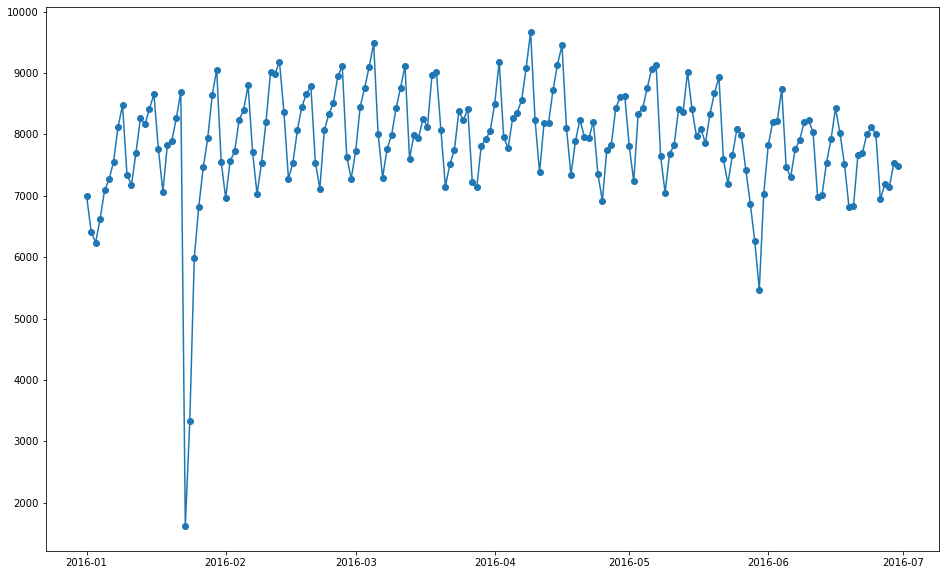

In [9]:
#plot the pickup dates by amount per day
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.show()

In [10]:
#most impactful 
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    earth_radius = 6371 #in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return h

In [11]:
#this is the haversine above x2 
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat2, lng2)
    b = haversine_array(lat1, lng1, lat2, lng2)
    return a + b

In [12]:
#this is the direction the the taxi was heading
def bearing_array(lat1, lng1, lat2, lng2):
    earth_radius = 6371 #in km  
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) *np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [13]:
#creating variables for each row
p_lat = train['pickup_latitude'].values
p_lon = train['pickup_longitude'].values
d_lat = train['dropoff_latitude'].values
d_lon = train['dropoff_longitude'].values

In [14]:
#create new columns with distances calculated
train.loc[:, 'distance_haversine'] = haversine_array(p_lat, p_lon, d_lat, d_lon)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(p_lat, p_lon, d_lat, d_lon)
train.loc[:, 'direction'] = bearing_array(p_lat, p_lon, d_lat, d_lon)

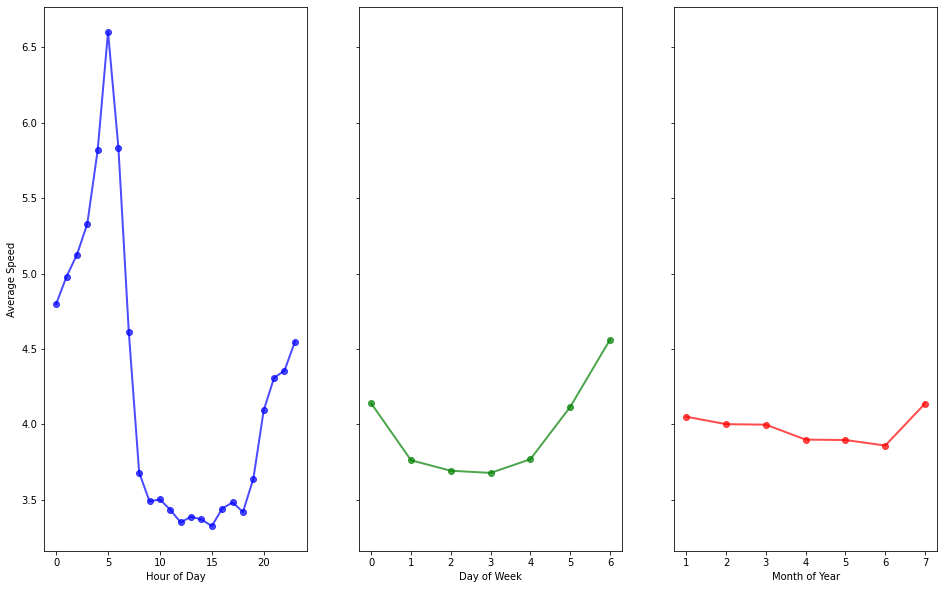

In [15]:
#show other datetime stats
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
plt.show()

In [16]:
hours = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values))
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'Month', 'DayofMonth', 'Hour',
       'dayofweek', 'dropoff_date', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'avg_speed_h', 'avg_speed_m'],
      dtype='object')

In [17]:
#create KMeans object
km = KMeans(n_clusters=100)

In [18]:
#Use K-Means to cluster the pickup locations and use the location cluster IDs as input to XGBoost to predict trip duration
p_coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values))

In [19]:
#fit the pickup locations to th KMeans object
km.fit(p_coords)

KMeans(n_clusters=100)

In [20]:
#Predict cluster IDs and create a column for them
train.loc[:, 'pickup_cluster'] = km.predict(train[['pickup_latitude', 'pickup_longitude']])
pickup_cluster = train['pickup_cluster']

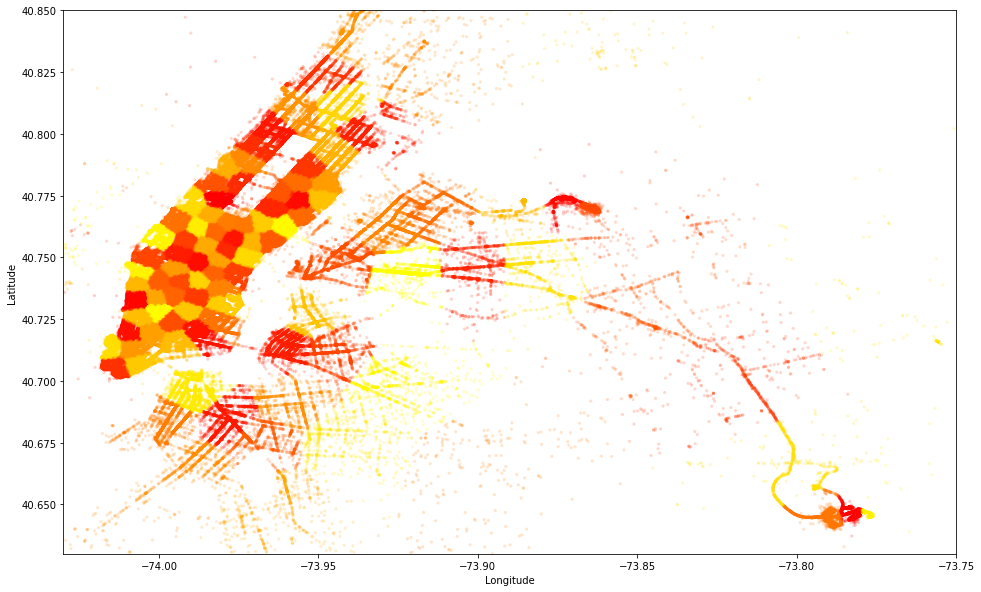

In [21]:
#plot out the data and clusters
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values, train.pickup_latitude.values, s=10, lw=0, 
           c=train.pickup_cluster.values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [22]:
#Use K-Means to cluster the pickup hours and use the hour cluster ID as input to XGBoost to predict trip duration
hour = train['Hour']
km.fit(p_coords, sample_weight=hour)

KMeans(n_clusters=100)

In [23]:
train.loc[:, 'hour_cluster'] = km.predict(p_coords, sample_weight=hour)

In [24]:
#Use K-Means to find similar Manhattan routes and plot them using ArcGIS Pro
y = train['trip_duration']
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values))

In [25]:
km.fit(coords, sample_weight=y)

KMeans(n_clusters=100)

In [26]:
train.loc[:, 'trip_cluster'] = km.predict(coords, sample_weight=y)

In [27]:
X = train.drop(['id', 'avg_speed_h', 'vendor_id', 'store_and_fwd_flag', 'pickup_date', 'dropoff_date', 'pickup_datetime', 'dropoff_datetime', 'avg_speed_m', 'trip_duration'], axis=1)

In [28]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [30]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[20:17:30] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:30] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:610.65375	valid-rmse:612.61450
[1]	train-rmse:432.11054	valid-rmse:433.95407
[2]	train-rmse:367.61404	valid-rmse:369.47888
[3]	train-rmse:345.88892	valid-rmse:347.66779
[4]	train-rmse:333.92969	valid-rmse:335.77020
[5]	train-rmse:328.40228	valid-rmse:330.32101
[6]	train-rmse:324.62054	valid-rmse:326.63272
[7]	train-rmse:320.21191	valid-rmse:322.30414
[8]	train-rmse:317.40012	valid-rmse:319.65936
[9]	train-rmse:314.79425	valid-rmse:317.14722
Modeling RMSLE 317.14722


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

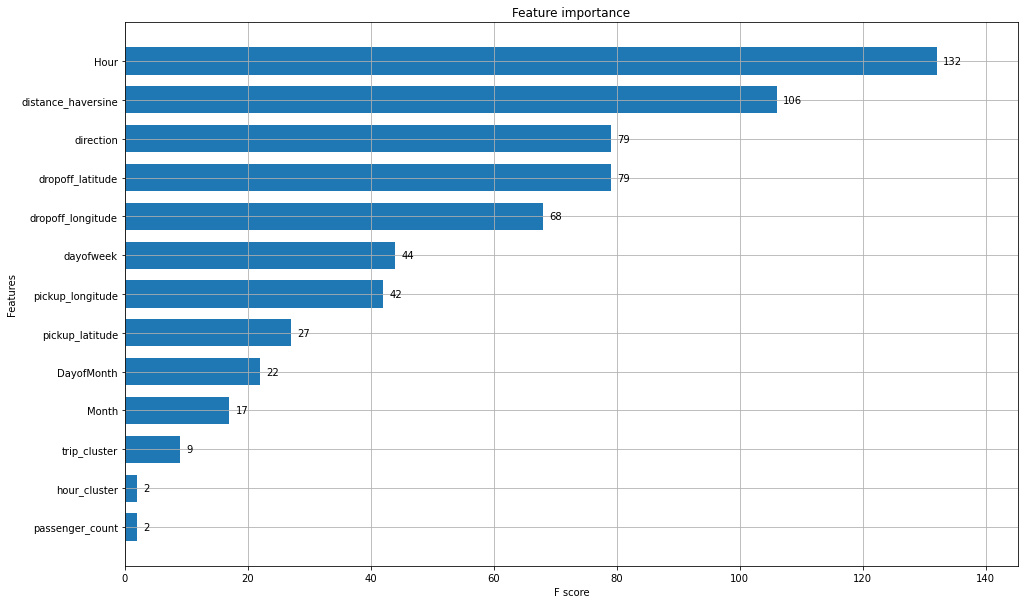

In [31]:
xgb.plot_importance(model, max_num_features=30, height=0.7)